In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
# Step 1: Preprocess stock price data (normalize, create time windows)

# Download stock data from Yahoo Finance for Google (GOOG)
df_train = yf.download('GOOG', start='2013-01-01', end='2023-12-31')
df_test = yf.download('GOOG', start='2024-01-01', end='2024-12-31')

# We are using 'Close' prices for prediction
train_data = df_train[['Close']]
test_data = df_test[['Close']]

# Scaling data using MinMaxScaler (normalize values between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Function to create time windows for LSTM
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Define time_step (number of previous days to use for predicting the next day)
time_step = 60
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# Reshaping data for LSTM model input (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [15]:
# Step 2: Define the LSTM-based time series forecasting model

# LSTM Model Architecture
model = Sequential()

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1))))
model.add(Dropout(0.2))  # Dropout to reduce overfitting

model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
model.add(Dropout(0.2))

# Fully connected layer to output the prediction
model.add(Dense(units=1))

# Compile the model using Adam optimizer and Mean Squared Error (MSE) loss
model.compile(optimizer='adam', loss='mean_squared_error')



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Step 3: Train the model on the past stock price trends

# Early stopping to prevent overfitting (stopping if validation loss doesn't improve for 10 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], verbose=1)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 470ms/step - loss: 8.9730e-04 - val_loss: 0.0010
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 336ms/step - loss: 6.7139e-04 - val_loss: 0.0010
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 362ms/step - loss: 6.0397e-04 - val_loss: 0.0011
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - loss: 7.4418e-04 - val_loss: 0.0022
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 342ms/step - loss: 6.3325e-04 - val_loss: 0.0040
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - loss: 7.8375e-04 - val_loss: 0.0015
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 342ms/step - loss: 6.1395e-04 - val_loss: 9.6724e-04
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - loss: 5.8983e-04 - val_loss: 0.0011
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - loss: 5.6515e-04 - val_loss: 0.0020
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step - loss: 5.6984e-04 - val_loss: 0.0022
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 342ms/step - loss: 5.5668e-04 - val_loss: 

85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


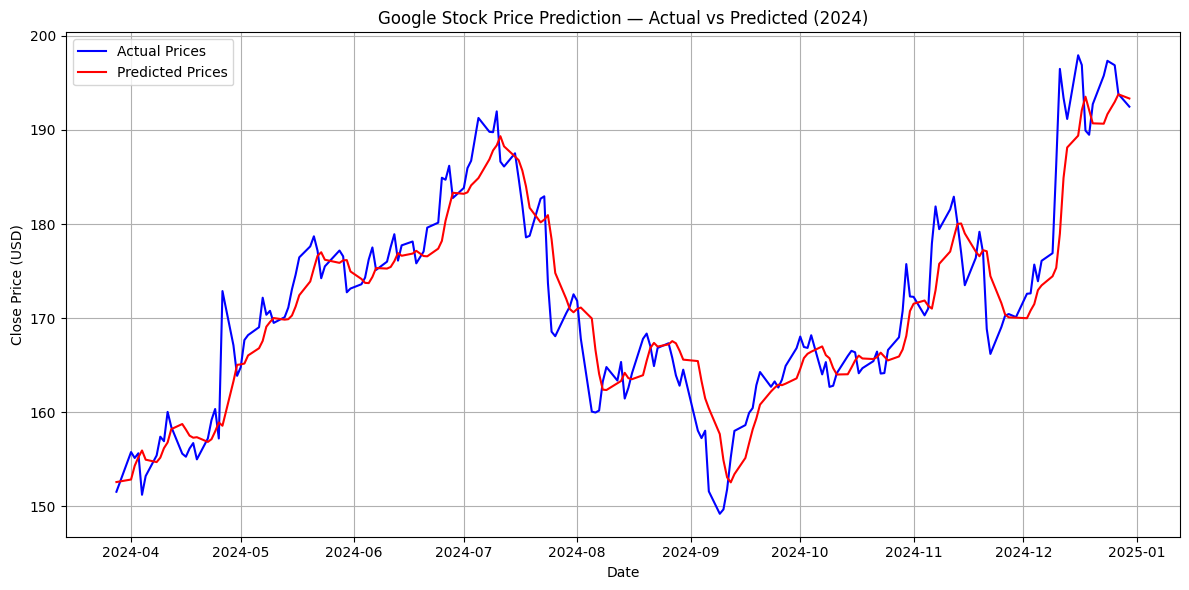

Mean Absolute Error (MAE): 2.8059
Mean Squared Error (MSE): 14.7743
R² Score: 0.8788


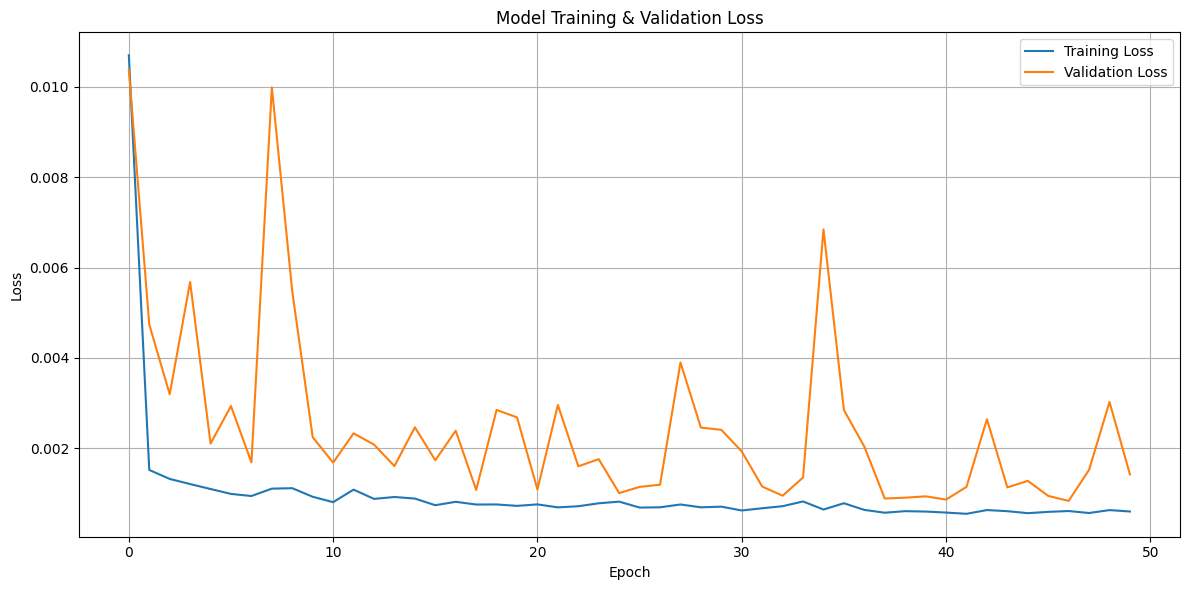

In [12]:

# Step 4: Evaluate performance and visualize future predictions

# Generate predictions
train_pred = model.predict(X_train)
test_pred  = model.predict(X_test)

# Inverse-transform to original scale
train_pred_scaled = scaler.inverse_transform(train_pred)
y_train_actual    = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred_scaled  = scaler.inverse_transform(test_pred)
y_test_actual     = scaler.inverse_transform(y_test.reshape(-1, 1))

# Align dates for plotting: drop the first 'time_step' days
aligned_dates = df_test.index[time_step:]

# Flatten arrays for plotting
test_actual_flat = y_test_actual.flatten()
test_pred_flat   = test_pred_scaled.flatten()

# Plot Actual vs Predicted for 2024
plt.figure(figsize=(12, 6))
plt.plot(aligned_dates, test_actual_flat, label='Actual Prices', color='blue')
plt.plot(aligned_dates, test_pred_flat,   label='Predicted Prices', color='red')
plt.title('Google Stock Price Prediction — Actual vs Predicted (2024)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute evaluation metrics
mae = mean_absolute_error(y_test_actual, test_pred_scaled)
mse = mean_squared_error(y_test_actual, test_pred_scaled)
r2  = r2_score(y_test_actual, test_pred_scaled)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R² Score: {r2:.4f}')

# Optional: Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'],     label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()